# 4-7. 프로젝트: CutMix 또는 Mixup 비교실험 하기
지금까지 기본적인 augmentation 방법을 적용해 모델을 훈련시키고, 최신 augmentation 기법을 배워 보았습니다.

이번에는 최신 기법(CutMix 또는 Mixup)을 적용해 모델을 훈련시켜 봅시다. 데이터셋에 두 가지 방법 중 하나를 적용하고, 모델을 학습시켜 주세요. 결과를 수치화하고 비교하는 것도 잊지 마세요!

우선 주요 라이브러리 버전을 확인해 볼까요?

In [1]:
import tensorflow as tf
import numpy as np

from tensorflow import keras
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

print(tf.__version__)
print(np.__version__)

2.6.0
1.21.4


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

print('number of train dataset :', len(ds_train))
print('number of test dataset :', len(ds_test))

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /aiffel/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.
number of train dataset : 12000
number of test dataset : 8580


In [4]:
# feature 정보 확인
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})


In [5]:
# 클래스의 개수 확인
num_classes = ds_info.features["label"].num_classes
print('class 개수 :', num_classes)

class 개수 : 120


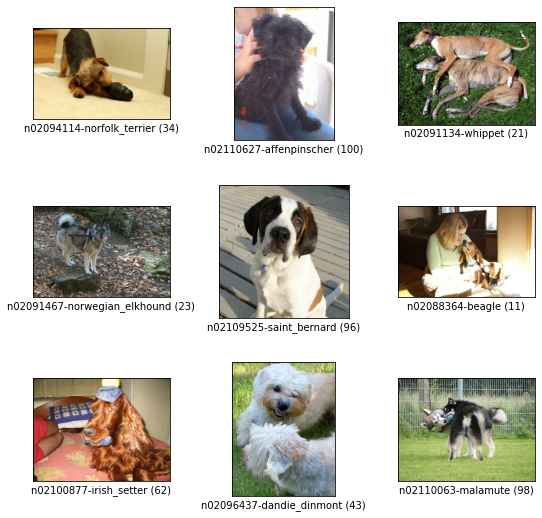

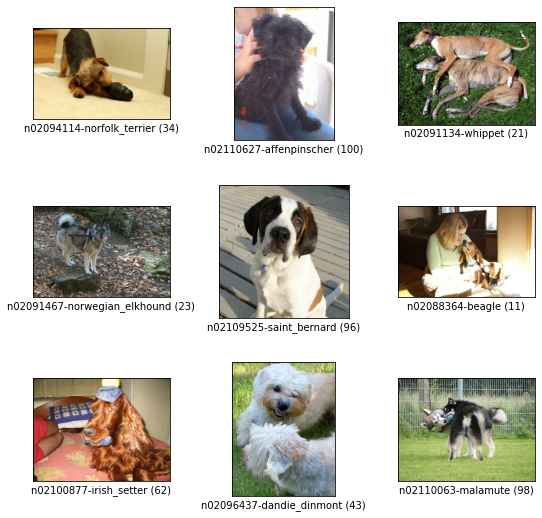

In [6]:
tfds.show_examples(ds_train, ds_info)

### 1. Augmentation을 적용한 데이터셋 만들기

이전 스텝과 아래 코드를 참고하여 데이터셋에 CutMix 또는 Mixup augmentation을 적용해 주세요.

In [7]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
        
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
            
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

### Augmentation 적용하지 않은 데이터셋

In [8]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train)
ds_test_no_aug  = apply_normalize_on_dataset(ds_test, is_test=True)

### 기본 Augmentation 적용한 데이터셋

In [9]:
# 기본 Augmentation 적용한 데이터셋 생성
ds_train_base_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_test_base_aug = apply_normalize_on_dataset(ds_test,  with_aug=True, is_test=True)

### Cutmix 적용한 데이터셋

#### Step 1) 이미지 섞기

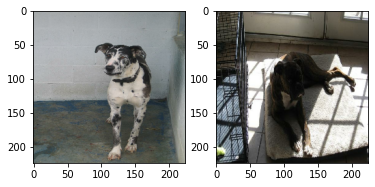

In [10]:
# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

In [11]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+height//2)
    
    return x_min, y_min, x_max, y_max

x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x : ', x_min, x_max)
print('y : ', y_min, y_max)

x :  tf.Tensor(0, shape=(), dtype=int32) tf.Tensor(175, shape=(), dtype=int32)
y :  tf.Tensor(0, shape=(), dtype=int32) tf.Tensor(88, shape=(), dtype=int32)


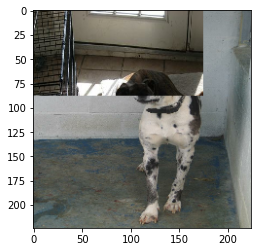

In [12]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
plt.imshow(mixed_img.numpy())
plt.show()

#### Step 2) 라벨 섞기

In [13]:
# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.     

In [14]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [15]:
ds_train_cutmix_aug = apply_normalize_on_dataset(ds_train, with_cutmix=True) 
ds_test_cutmix_aug  = apply_normalize_on_dataset(ds_test,  with_cutmix=True, is_test=True)

### Mixup 적용한 데이터셋

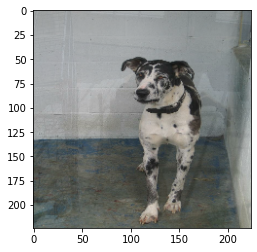

tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.08553076 0.         0.         0.         0.91446924
 0.         0.         0.         0. 

In [16]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
plt.show()
print(mixed_label)

In [17]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

### Mixup 적용한 데이터셋

In [18]:
ds_train_mixup_aug = apply_normalize_on_dataset(ds_train, with_mixup=True) 
ds_test_mixup_aug  = apply_normalize_on_dataset(ds_test,  with_mixup=True, is_test=True)

### 2. 모델 만들기

앞서 만들었던 것처럼 비교 실험을 위한 모델 두 개를 만들어 주세요. 모델은 ResNet-50을 사용합시다.

In [19]:
# Augmentation을 적용하지 않은 데이터셋을 적용할 ResNet 50
resnet50_no_aug = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,    
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

94781440/94765736 [==============================] - 0s 0us/step


In [20]:
# 기본 Augmentation을 적용한 데이터셋을 적용할 ResNet 50
resnet50_base_aug = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,    
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [21]:
# CutMix을 적용한 데이터셋을 적용할 ResNet 50 
resnet50_cutmix_aug = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,    
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [22]:
# Mixup을 적용한 데이터셋을 적용할 ResNet 50
resnet50_mixup_aug = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,   
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

### 3. 모델 훈련하기
모델을 훈련시켜 주세요.

주의!! 위에서 만든 CutMix나 Mixup을 사용하기 위해서는 앞에서 resnet50과 aug_resnet50을 훈련하는 데 사용했던 sparse_categorical_crossentropy() 대신 categorical_crossentropy()를 사용해 주세요!

### 기본 Augmentation 적용한 데이터셋

In [23]:
BATCH_SIZE = 16
EPOCH = 20

tf.random.set_seed(777)

In [28]:
resnet50_no_aug.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50_no_aug.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test_no_aug,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 180s 230ms/step - loss: 2.1872 - accuracy: 0.4518 - val_loss: 3.0867 - val_accuracy: 0.2506
Epoch 2/20
750/750 [==============================] - 158s 210ms/step - loss: 0.7630 - accuracy: 0.7874 - val_loss: 1.0501 - val_accuracy: 0.6896
Epoch 3/20
750/750 [==============================] - 157s 210ms/step - loss: 0.2559 - accuracy: 0.9423 - val_loss: 0.9606 - val_accuracy: 0.7153
Epoch 4/20
750/750 [==============================] - 157s 210ms/step - loss: 0.1187 - accuracy: 0.9810 - val_loss: 0.9692 - val_accuracy: 0.7191
Epoch 5/20
750/750 [==============================] - 157s 210ms/step - loss: 0.0397 - accuracy: 0.9973 - val_loss: 0.9266 - val_accuracy: 0.7332
Epoch 6/20
750/750 [==============================] - 157s 209ms/step - loss: 0.0179 - accuracy: 0.9992 - val_loss: 0.9162 - val_accuracy: 0.7414
Epoch 7/20
750/750 [==============================] - 157s 210ms/step - loss: 0.0117 - accuracy: 0.9995 - val_loss: 0.9224 -

In [24]:
resnet50_base_aug.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_base_aug = resnet50_base_aug.fit(
    ds_train_base_aug, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test_base_aug,
    verbose=1,
    use_multiprocessing=True,
)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/20
750/750 [==============================] - 172s 204ms/step - loss: 2.2798 - accuracy: 0.4374 - val_loss: 2.6640 - val_accuracy: 0.3217
Epoch 2/20
750/750 [==============================] - 157s 210ms/step - loss: 0.9442 - accuracy: 0.7270 - val_loss: 1.2795 - val_accuracy: 0.6363
Epoch 3/20
750/750 [==============================] - 157s 210ms/step - loss: 0.5073 - accuracy: 0.8600 - val_loss: 1.0681 - val_accuracy: 0.6887
Epoch 4/20
750/750 [==============================] - 157s 209ms/step - loss: 0.2634 - accuracy: 0.9375 - val_loss: 1.0315 - val_accuracy: 0.7048
Epoch 5/20
750/750 [==============================] - 157s 210ms/step - loss: 0.1497 - accuracy: 0.9695 - val_loss: 1.0338 - val_accuracy: 0.7100
Epoch 6/20
750/750 [==============================] - 159s 212ms/step - loss: 0.0917 - accuracy: 0.9859 - val_loss: 0.9642 - val_accuracy: 0.7320
Epoch 7/20
750/750 [==============================] - 157s 210ms/step - loss: 0.0538 - accuracy: 0.9927 - val_loss: 0.9744 -

### Cutmix 적용한 데이터셋

In [25]:
resnet50_cutmix_aug.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_cutmix_aug = resnet50_cutmix_aug.fit(
    ds_train_cutmix_aug,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test_cutmix_aug,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 167s 213ms/step - loss: 3.8104 - accuracy: 0.2176 - val_loss: 3.6425 - val_accuracy: 0.1684
Epoch 2/20
750/750 [==============================] - 159s 212ms/step - loss: 2.9284 - accuracy: 0.4399 - val_loss: 1.3884 - val_accuracy: 0.6157
Epoch 3/20
750/750 [==============================] - 159s 212ms/step - loss: 2.6197 - accuracy: 0.5383 - val_loss: 1.2669 - val_accuracy: 0.6462
Epoch 4/20
750/750 [==============================] - 159s 212ms/step - loss: 2.3991 - accuracy: 0.6048 - val_loss: 1.1931 - val_accuracy: 0.6783
Epoch 5/20
750/750 [==============================] - 159s 212ms/step - loss: 2.2436 - accuracy: 0.6617 - val_loss: 1.2328 - val_accuracy: 0.6650
Epoch 6/20
750/750 [==============================] - 159s 212ms/step - loss: 2.1299 - accuracy: 0.6989 - val_loss: 1.2089 - val_accuracy: 0.6673
Epoch 7/20
750/750 [==============================] - 159s 211ms/step - loss: 2.0523 - accuracy: 0.7293 - val_loss: 1.3245 -

### Mixup 적용한 데이터셋

In [26]:
resnet50_mixup_aug.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_mixup_aug = resnet50_mixup_aug.fit(
    ds_train_mixup_aug,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test_mixup_aug,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 167s 212ms/step - loss: 3.7785 - accuracy: 0.2208 - val_loss: 5.7659 - val_accuracy: 0.0754
Epoch 2/20
750/750 [==============================] - 159s 211ms/step - loss: 2.8892 - accuracy: 0.4619 - val_loss: 1.6859 - val_accuracy: 0.5354
Epoch 3/20
750/750 [==============================] - 158s 211ms/step - loss: 2.6029 - accuracy: 0.5732 - val_loss: 1.4080 - val_accuracy: 0.6083
Epoch 4/20
750/750 [==============================] - 158s 211ms/step - loss: 2.4348 - accuracy: 0.6430 - val_loss: 1.3883 - val_accuracy: 0.6219
Epoch 5/20
750/750 [==============================] - 158s 211ms/step - loss: 2.2631 - accuracy: 0.7020 - val_loss: 1.3271 - val_accuracy: 0.6402
Epoch 6/20
750/750 [==============================] - 158s 211ms/step - loss: 2.1634 - accuracy: 0.7391 - val_loss: 1.2494 - val_accuracy: 0.6546
Epoch 7/20
750/750 [==============================] - 158s 211ms/step - loss: 2.0766 - accuracy: 0.7743 - val_loss: 1.1900 -

### 4. 훈련 과정 시각화하기
훈련 과정의 히스토리를 그래프로 시각화해 주세요.

### 5. Augmentation에 의한 모델 성능 비교
No Augmentation, 기본 Augmentation, 기본 + CutMix 적용, 기본 + Mixup 적용 이상 4가지 경우의 데이터셋에 대해 훈련된 ResNet50 분류기의 견종 분류 정확도 성능을 비교해 보고, Augmentation 방법들의 영향도에 대해 분석해 보세요.

### No Augmentation vs 기본 Augmentation

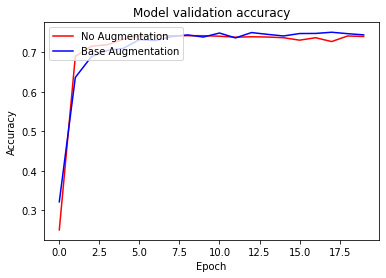

In [29]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_base_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'Base Augmentation'], loc='upper left')
plt.show()

### 기본 Augmentation vs Cutmix

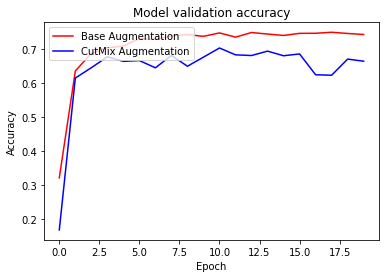

In [30]:
plt.plot(history_resnet50_base_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_cutmix_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Base Augmentation', 'CutMix Augmentation'], loc='upper left')
plt.show()

### 기본 Augmentation vs Mixup

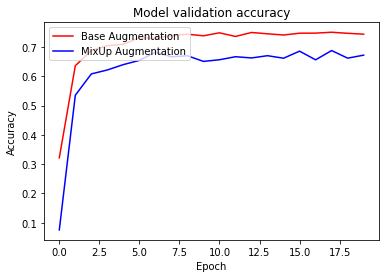

In [31]:
plt.plot(history_resnet50_base_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_mixup_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Base Augmentation', 'MixUp Augmentation'], loc='upper left')
plt.show()

## 프로젝트 결과 및 회고
- 이번 프로젝트는 다양한 Augmentation을 통해 이미지를 생성하여 데이터셋을 보강하는 프로젝트입니다.
- 기본적인 Augmentation과 Cutmix, Mixup Augmentation을 통해 기존의 데이터셋에서 새로운 이미지를 생성하고 이를 데이터셋에 추가한다음 동등하게 Resnet 50 모델로 학습시켜 결과가 얼마나 달라지는지 확인해 보았습니다.
- accuracy 기준으로 보았을 때 기본 Augmentation을 적용한 경우에 가장 높은 정확도를 얻을 수 있었으며 다음은 No Augmentation, Cutmix와 Mixup은 상대적으로 낮은 정확도를 확인할 수 있었습니다. Validation 데이터를 활용하여 검증해본 결과는 augmentation을 활용한 데이터셋의 경우에는 오버피팅을 어느정도 해결하는 것을 확인할 수 있었습니다.
- 모델을 학습시키는데 생각보다 많은 시간이 소요되어 다양한 변화값으로 실험해 보지 못한 점이 아쉬웠습니다.
- 이러한 결과를 통해 데이터셋이 부득이하게 적은 상태인 경우 Augmentation을 통해 데이터셋을 보강하여 오버피팅을 해소할 수 있다는 것을 알게 되었습니다.